In [69]:
# Standard Packages
import pandas as pd
import numpy as np
import regex as re
import itertools
import pickle

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# SKLearn Modules
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# NLTK modules
import nltk
from nltk import FreqDist, WordNetLemmatizer, pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet

# Word2Vec
from gensim.models import word2vec

# Suppress future, deprecation, and SettingWithCopy warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

# make all columns in a df viewable and wider
pd.options.display.max_columns = None
pd.options.display.width = None
pd.set_option('max_colwidth', 400)

## Data
I used [the ISOT Fake News dataset by Hadeer Ahmed, Issa Traore, and Sherif Saad and disseminated through the Information Security and Object Technology (ISOT) Research Group at the University of Victoria](https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/) to train my model. The dataset includes 21417 real news articles and 23481 fake news articles from 2016 and 2017, and covers a variety of topics including US and world politics and news, along with other current affairs topics. [According to the creators of the dataset](https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/02/ISOT_Fake_News_Dataset_ReadMe.pdf): "This dataset was collected from realworld sources; the truthful articles were obtained by crawling articles from Reuters.com (News website). As for the fake news articles, they were collected from different sources. The fake news
articles were collected from unreliable websites that were flagged by Politifact (a fact-checking
organization in the USA) and Wikipedia." When examining the data, we'll have to see how the source of the truthful and false news articles may impact our approach to cleaning and processing.

In [2]:
# load in real news
realnews = pd.read_csv('data/True.csv')

# set target column to 0
realnews['target'] = 0
realnews

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a ...",politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administra...",politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, sai...",politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence in...",politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past. “Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packa...",politicsNews,"December 29, 2017",0
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach on Afghanistan,"BRUSSELS (Reuters) - NATO allies on Tuesday welcomed President Donald Trump s decision to commit more forces to Afghanistan, as part of a new U.S. strategy he said would require more troops and funding from America s partners. Having run for the White House last year on a pledge to withdraw swiftly from Afghanistan, Trump reversed course on Monday and promised a stepped-up military campaign ag...",worldnews,"August 22, 2017",0
21413,LexisNexis withdrew two products from Chinese market,"LONDON (Reuters) - LexisNexis, a provider of legal, regulatory and business information, said on Tuesday it had withdrawn two products from the Chinese market in March this year after it was asked to remove some content. The issue of academic freedom in China hit the headlines this week after the leading British academic publisher, Cambridge University Press, said it had complied with a requ...",worldnews,"August 22, 2017",0
21414,Minsk cultural hub becomes haven from authorities,"MINSK (Reuters) - In the shadow of disused Soviet-era factories in Minsk, a street lined with eclectic bars, art galleries and yoga studios has become a haven from the vigilant eyes of the Belarussian authorities. This place is like an island, said Yegor, 21, who works at popular bar Hooligan. It s the street of freedom. The government of President Alexander Lukashenko, who has rul

In [3]:
print(realnews['text'][0])

WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educati

In [4]:
# load in fake news
fakenews = pd.read_csv('data/Fake.csv')

# set target column to 1
fakenews['target'] = 1
fakenews

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dis...",News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained...",News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt....",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf includin...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned Trump s move to recognize Jerusalem as the capital of Israel. The Pontiff prayed on Monday for the peaceful coexistence of two states within mutually agreed and internationally recognized borders. We ...,News,"December 25, 2017",1
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated US Sailors Well,"21st Century Wire says As 21WIRE reported earlier this week, the unlikely mishap of two US Naval vessels straying into Iranian waters just hours before the President s State of the Union speech, followed by the usual parade of arch-neocons coming on TV in real time to declare the incident as an act of aggression by Iran against the United States is no mere coincidence.24 hours after th...",Middle-east,"January 16, 2016",1
23477,"JUSTICE? Yahoo Settles E-mail Privacy Class-action: $4M for Lawyers, $0 for Users","21st Century Wire says It s a familiar theme. Whenever there is a dispute or a change of law, and two tribes go to war, there is normally only one real winner after the tribulation the lawyers. Ars TechnicaIn late 2013, Yahoo was hit with six lawsuits over its practice of using automated scans of e-mail to produce targeted ads. The cases, which were consolidated in federal court, all argued t...",Middle-east,"January 16, 2016",1
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to Take Territorial Booty in Northern Syria,"Patrick Henningsen 21st Century WireRemember when the Obama Administration told the world how it hoped to identify 5,000 reliable non-jihadist moderate rebels hanging out in Turkey and Jordan, who might want to fight for Washington in Syria? After all the drama over its infamous train and equip pr

Immediately we can see that in the real news data, each article starts with the city where the report is coming from and '(Reuters)'. In the fake news data, on the other hand, some of the text does not have any identifying information at the head of the article, while others do. We'll have to keep that difference in mind when beginning to process and model the data.

For now, let's concatenate these dataframes and drop the subject and date columns to have a complete dataset.

In [5]:
# combine fake and real news dfs
news = pd.concat([realnews, fakenews]).reset_index()
news.drop(['index', 'subject', 'date'], axis = 1, inplace = True)
news

,title,text,target
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a ...",0
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administra...",0
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, sai...",0
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence in...",0
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past. “Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packa...",0
...,...,...,...
44893,McPain: John McCain Furious That Iran Treated US Sailors Well,"21st Century Wire says As 21WIRE reported earlier this week, the unlikely mishap of two US Naval vessels straying into Iranian waters just hours before the President s State of the Union speech, followed by the usual parade of arch-neocons coming on TV in real time to declare the incident as an act of aggression by Iran against the United States is no mere coincidence.24 hours after th...",1
44894,"JUSTICE? Yahoo Settles E-mail Privacy Class-action: $4M for Lawyers, $0 for Users","21st Century Wire says It s a familiar theme. Whenever there is a dispute or a change of law, and two tribes go to war, there is normally only one real winner after the tribulation the lawyers. Ars TechnicaIn late 2013, Yahoo was hit with six lawsuits over its practice of using automated scans of e-mail to produce targeted ads. The cases, which were consolidated in federal court, all argued t...",1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to Take Territorial Booty in Northern Syria,"Patrick Henningsen 21st Century WireRemember when the Obama Administration told the world how it hoped to identify 5,000 reliable non-jihadist moderate rebels hanging out in Turkey and Jordan, who might want to fight for Washington in Syria? After all the drama over its infamous train and equip program to create their own Arab army in Syria, they want to give it another try.This week, Pen...",1
44896,How to Blow $700 Million: Al Jazeera America Finally Calls it Quits,"21st Century Wire says Al Jazeera America will go down in history as one of the biggest failu

In [6]:
# get percentage of each class
news['target'].value_counts(normalize = True)

1    0.522985
0    0.477015
Name: target, dtype: float64

Our classes are roughly balanced, which will be helpful for assessing the accuracy of our model. Since about 52% of the articles in the dataset are fake, we'll want to see our model perform much better than that to indicate it is performing well.

## Data Cleaning and EDA
### Removing Links, Hashtags, and Other Non-Semantic Information

Let's take a look at a few random rows from the data to see what kind of cleaning may be necessary before we can vectorize our text:

In [7]:
# examine random sample of rows
news.sample(n=10)

,title,text,target
39792,WATCH: HILARIOUS Video Shows Reddit User Apologizing To “Terror Organization” CNN After They Threatened To “Out” Him To Public,"When CNN, who is owned by multi-billion dollar corporation Time-Warner threatened to out a private individual for doctoring a wrestling video of Donald Trump and replacing his face with a CNN logo, most Americans were stunned.#VeryFakeNewsCNN is likely going to rue the day they threatened a Reddit user that they would expose his identity to leftist thugs, as punishment for doctoring a video ...",1
25634,"Watch Joe Biden Tells Us EXACTLY What Trump Is, BRILLIANTLY Rips Him From End To End (VIDEO)","With more and more coming out about Republican presidential candidate Donald Trump, it s become abundantly clear that he in no way should be allowed near the Oval Office.Between his racism, sexism, Islamophobia, insulting disabled people as well as Gold Star families, and now the leaked Access Hollywood footage which is leading to women everywhere to reveal they ve been sexually assaulted by T...",1
10814,Scalia's death boosts legal chances for Obama's climate plan,"WASHINGTON (Reuters) - A vote to block the Obama administration’s ambitious climate regulation was one of Antonin Scalia’s last acts as a Supreme Court justice. His sudden death may have opened a new path to the rule’s survival. Scalia died Saturday. Four days earlier, he voted with the other conservative members of the high court to put a hold on the administration’s plans to implement the Cl...",0
24520,Lindsey Graham Calls Out His Own Party; Says Republicans Aren’t Patriotic (VIDEO),"S.C. Senator Lindsey Graham has been a shining beacon in the Republican Party when it comes to the Russian hacking scandal. He knows that no matter what party it benefited, it s beyond dangerous to let a foreign government, especially a foreign nuclear power, gain control over our elections.On Sunday s Meet the Press, Graham laid down a pretty brutal truth bomb for Republicans, calling them p...",1
32162,"DONALD TRUMP JR. Blasts “Comedian” KATHY GRIFFIN After She Poses In Gruesome Photo Holding President Trump’s Bloody, Decapitated Head",The outspoken comedian posed for a photo shoot with controversial photographer Tyler Shields in which she is holding a bloodied mask of President Trump.***WARNING***Photo is graphic and could be confused with an act of terror by an ISIS terrorist:Here s the gruesome ISIS inspired video that Griffin posted to Twitter:https://twitter.com/kathygriffin/status/869654650844098562TMZ published the go...,1
8066,Senate clears way for $1.15 billion arms sale to Saudi Arabia,"WASHINGTON (Reuters) - The U.S. Senate cleared the way for a $1.15 billion sale of tanks and other military equipment to Saudi Arabia on Wednesday, defending a frequent partner in the Middle East recently subject to harsh criticism in Congress. The Senate voted 71 to 27 to kill legislation that would have stopped the sale. The overwhelming vote stopped an effort led by Republican Senator Rand ...",0
28804,"WATCH: Bernie Sanders Visits U.S. Border, Delivers Brutal Truth About Trump (VIDEO)","Bernie Sanders visited the United States-Mexico border in Nogales, Arizona to witness one area that will be most affected by U.S. immigration policy. Sanders then spoke to a large crowd about his time listening to the stories of immigrants and the need to create a reality-based immigration policy that puts compassion first. As I have traveled around this country and talked to immigrant famil...",1
26729,Even The Dad Of Pro-Trump Act ‘USA Freedom Kids’ Plans To Sue Campaign,"The U.S.A. Freedom Kids performed at a rally for Donald Trump in Florida last January and played a song containing lyrics which were terrifying unless you re pro-war. After that, the kids were a hit, featured at media appearances, with the three pre-teen girls even telling Inside Edition that Donald told them that he planned to listen to their CD all night long. However, that cozy relation

There is a lot of cleaning that will need to be done before this data is ready for modeling. From running the sampler above several times we can see that there are URLs in the text, along with punctuation, words that are fully capitalized, and the previously mentioned dateline information at the start of the real articles.

Before we begin with any cleaning, we'll need to perform a train test split to avoid data leakage. For our initial modeling, we'll focus on the text of the article instead of the title. We'll leave the test size at the default value so we can train the model on about 34,000 rows of data and test it on the remaining 11,000.

In [8]:
# define feature and target
X = news.drop('target', axis = 1)
y = news['target']

# perform split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

Now that we've split the data, we can begin processing the text. Let's start with a basic step: making all the characters lowercase.

In [9]:
# make all characters lowercase
X_train["text"] = X_train["text"].str.lower()
X_train.head(2)

,title,text
34830,"TRUMP DELIVERS MESSAGE TO PUTIN: “Russia, If You’re Listening…I Hope You’re Able To Find The 30,000 Emails That Are Missing” [VIDEO]","trump says he s never talked to putin and the allegation that he is working with him to expose hillary s emails is ridiculous. putin has been threatening the release of 20,000 emails from hillary s private server, and the press is trying to tie his threat to trump. unlike previous gop presidential candidates s trump s not going to sit back and allow the press to define the narrative. he s gett..."
6018,Trump says he will 'absolutely do safe zones' in Syria,"washington (reuters) - u.s. president donald trump said he “will absolutely do safe zones in syria” to protect people fleeing violence there. “i’ll absolutely do safe zones in syria for the people,” trump said in an interview with abc news broadcast on wednesday. “i think that europe has made a tremendous mistake by allowing these millions of people to go into germany and various other countri..."


We also know that at least some of the articles include links to other websites, to Twitter accounts, to hashtags, or to images. These links won't contribute any semantic value to our model, so we should remove them as well. We can do so by using regex to replace URLs with blanks:

In [10]:
def replace_links(string):
    '''
    A function that takes in a string as an input. 
    
    Uses a regex expression to detect URLs that start with http, https, pic.twitter, or www.; 
    Twitter account names (which start with @); and hashtags (which start with #) and replaces 
    them with a blank.
    
    Returns the string with that substitution made.
    '''
    url_pattern = r'(?:http|https|pic\.twitter|www\.)\S+|@\S+|^@\S+|#\S+'
    return re.sub(url_pattern, '', string, flags=re.IGNORECASE)

In [11]:
# map this function onto the text column
X_train['text'] = X_train['text'].map(replace_links)
X_train.sample(n=10, random_state = 270)

,title,text
16909,EU will cut some money for Turkey as ties sour,"brussels (reuters) - the european union will cut some of the money earmarked for turkey to join the bloc, reflecting increasingly sour ties with ankara but stopping short of killing membership bid of the country it still sees as a strategic partner. the eu has been walking a tight rope for months on turkey, angered by president tayyip erdogan s crackdown on critics after a failed coup in july,..."
13507,China vows more checks on teachers after kindergarten abuse scandal,"beijing (reuters) - china on thursday pledged stiffer oversight of preschool teachers, including closer checks on their qualifications, following an outcry over allegations of child abuse at a private kindergarten in beijing. the case has become a lighting rod for anger at a lack of trained teachers, low wages and poor oversight in china s massive and fast-growing private pre-school sector. c..."
6412,Tillerson says would support maintaining Russia sanctions for now,"washington (reuters) - president-elect donald trump’s nominee for u.s. secretary of state, rex tillerson, said on wednesday he would support maintaining u.s. sanctions on russia until the united states further develops its approach to the country. “i would leave things in the status quo so we are able to convey this can go either way,” tillerson said during his confirmation hearing, in respons..."
33420,THE OBAMAS MILK EVERY LAST MINUTE: Will Throw Final Taxpayer Funded Bash For “Major Donors”,"of course, there s no official word from the white house yet. typically the obama administration keeps a tight lid on celebration details until the 11th hour. but the big names thought to be on the guest list have been slowly trickling out this week.old standbys such as singer usher and actor samuel l. jackson will most likely be there, according to another person with knowledge of the invitee..."
35386,NOT KIDDING: ARIZONA NEWSPAPER Concerned Border Fence Too High For Illegals To Cross Safely,"when the fence keeps them from making it to the polls, the democrats start complaining a mainstream arizona newspaper is decrying the small section of the arizona-mexico border that has a 14-foot-high primary fence because it is too high for illegal immigrants to safely cross. the article, border fence jumpers breaking bones, includes the claim that sections of the border with a 14-foot-hig..."
42233,WATCH: HILARIOUS AD Calls Into Question Health Of Aging Clinton Crime Family Bosses,"after watching this telling video, you ll wonder if instead of working so hard to get back into the white house, hillary s time would be better spent looking into an assisted living situation for her and bill"
20195,"Juncker chides EU candidate Turkey, upbeat on Western Balkans",strasbourg (reuters) - the president of the european commission said on wednesday he saw no prospect of turkey joining the eu in the foreseeable future but he had a more optimistic message for six western balkan nations also seeking membership. the european union has become increasingly critical of turkey s decades-long membership drive after president tayyip erdogan launched a major crackdo...
32243,IS TIM ALLEN’S “Last Man Standing” About To Be Revived After “Passionate” Conservatives Express Outrage Over ABC’s Decision To Cancel Show?,"tim allen took to twitter to express his disappointment after discovering that the second highest rated comedy tv series on abc, last man standing was going to be cancelled:stunned and blindsided by the network i called home for the last six years. tim allen ( may 16, 2017many of his fans commented in support of his courage to stand up for his conservative views:thanks for standing up and ..."
8651,Trump pulls nearly even with Clinton after Republican convention: Reuters/Ipsos poll,"new york (reuters) - republican presidential nominee donald trump has pulled nearly even with democratic rival hillary clinton for the first time since may, according to a reuters/ipso

### Removing 'Reuters' to Avoid Leakage

From our visual examination of the corpus earlier, we also saw that "Reuters" is in nearly every "real" article, and very few of the "fake" ones.

In [12]:
# Create a boolean mask indicating which rows contain the word "Reuters"
real_reuters_mask = realnews['text'].str.contains('Reuters').sum()
fake_reuters_mask = fakenews['text'].str.contains('Reuters').sum()

# Print the boolean mask
print(f'The word Reuters appears in {real_reuters_mask} out of {realnews.shape[0]} total real news articles.')
print(f'The word Reuters appears in {fake_reuters_mask} out of {fakenews.shape[0]} total fake news articles.')

The word Reuters appears in 21378 out of 21417 total real news articles.
The word Reuters appears in 311 out of 23481 total fake news articles.


If we leave Reuters in, it will almost certainly artificially inflate the accuracy of our model because it would be able to lean almost exclusively on the presence of dateline information in making its classification decisions. Based on this imbalance, it seems we should remove the word Reuters from our corpus as well. Let's do that now:

In [13]:
X_train['text'] = X_train['text'].str.replace('reuters', '')
X_train.sample(n=10, random_state = 270)

,title,text
16909,EU will cut some money for Turkey as ties sour,"brussels () - the european union will cut some of the money earmarked for turkey to join the bloc, reflecting increasingly sour ties with ankara but stopping short of killing membership bid of the country it still sees as a strategic partner. the eu has been walking a tight rope for months on turkey, angered by president tayyip erdogan s crackdown on critics after a failed coup in july, 2016, ..."
13507,China vows more checks on teachers after kindergarten abuse scandal,"beijing () - china on thursday pledged stiffer oversight of preschool teachers, including closer checks on their qualifications, following an outcry over allegations of child abuse at a private kindergarten in beijing. the case has become a lighting rod for anger at a lack of trained teachers, low wages and poor oversight in china s massive and fast-growing private pre-school sector. claims t..."
6412,Tillerson says would support maintaining Russia sanctions for now,"washington () - president-elect donald trump’s nominee for u.s. secretary of state, rex tillerson, said on wednesday he would support maintaining u.s. sanctions on russia until the united states further develops its approach to the country. “i would leave things in the status quo so we are able to convey this can go either way,” tillerson said during his confirmation hearing, in response to a ..."
33420,THE OBAMAS MILK EVERY LAST MINUTE: Will Throw Final Taxpayer Funded Bash For “Major Donors”,"of course, there s no official word from the white house yet. typically the obama administration keeps a tight lid on celebration details until the 11th hour. but the big names thought to be on the guest list have been slowly trickling out this week.old standbys such as singer usher and actor samuel l. jackson will most likely be there, according to another person with knowledge of the invitee..."
35386,NOT KIDDING: ARIZONA NEWSPAPER Concerned Border Fence Too High For Illegals To Cross Safely,"when the fence keeps them from making it to the polls, the democrats start complaining a mainstream arizona newspaper is decrying the small section of the arizona-mexico border that has a 14-foot-high primary fence because it is too high for illegal immigrants to safely cross. the article, border fence jumpers breaking bones, includes the claim that sections of the border with a 14-foot-hig..."
42233,WATCH: HILARIOUS AD Calls Into Question Health Of Aging Clinton Crime Family Bosses,"after watching this telling video, you ll wonder if instead of working so hard to get back into the white house, hillary s time would be better spent looking into an assisted living situation for her and bill"
20195,"Juncker chides EU candidate Turkey, upbeat on Western Balkans",strasbourg () - the president of the european commission said on wednesday he saw no prospect of turkey joining the eu in the foreseeable future but he had a more optimistic message for six western balkan nations also seeking membership. the european union has become increasingly critical of turkey s decades-long membership drive after president tayyip erdogan launched a major crackdown on c...
32243,IS TIM ALLEN’S “Last Man Standing” About To Be Revived After “Passionate” Conservatives Express Outrage Over ABC’s Decision To Cancel Show?,"tim allen took to twitter to express his disappointment after discovering that the second highest rated comedy tv series on abc, last man standing was going to be cancelled:stunned and blindsided by the network i called home for the last six years. tim allen ( may 16, 2017many of his fans commented in support of his courage to stand up for his conservative views:thanks for standing up and ..."
8651,Trump pulls nearly even with Clinton after Republican convention: Reuters/Ipsos poll,"new york () - republican presidential nominee donald trump has pulled nearly even with democratic rival hillary clinton for the first time since may, according to a /ipsos poll taken o

Excellent - now we've removed links and the word "Reuters" from our corpus. Next, let's tokenize the corpus. Tokenization is important because it will ultimately allow us to vectorize our corpus, which is necessary for modeling. From visually examining this corpus, it appears that a fair number of the "fake" news articles have spelling issues that could lead to the creation of features that aren't useful for our modeling (e.g. missing apostrophes in contractions that would lead to the creation of meaningless one- or two- character tokens). There are also quite a few punctuation characters that were not captured as part of the cleaning above that need to be removed.

### Tokenizing the Text
Consequently, we'll tokenize our corpus using nltk's "RegexpTokenizer" method to select all words with three or more letters to capture words, or four or more consecutive numbers to capture years or large dollar amounts.

In [14]:
# define token pattern
basic_token_pattern = r"(?u)\b([a-zA-Z]{3,}|\d{4,})\b"

# instantiate tokenizer
tokenizer = RegexpTokenizer(basic_token_pattern)

# tokenize corpus text and return in a new column
X_train['tokenized_text'] = X_train['text'].apply(tokenizer.tokenize)

# inspect tokenized text
X_train.head()

,title,text,tokenized_text
34830,"TRUMP DELIVERS MESSAGE TO PUTIN: “Russia, If You’re Listening…I Hope You’re Able To Find The 30,000 Emails That Are Missing” [VIDEO]","trump says he s never talked to putin and the allegation that he is working with him to expose hillary s emails is ridiculous. putin has been threatening the release of 20,000 emails from hillary s private server, and the press is trying to tie his threat to trump. unlike previous gop presidential candidates s trump s not going to sit back and allow the press to define the narrative. he s gett...","[trump, says, never, talked, putin, and, the, allegation, that, working, with, him, expose, hillary, emails, ridiculous, putin, has, been, threatening, the, release, emails, from, hillary, private, server, and, the, press, trying, tie, his, threat, trump, unlike, previous, gop, presidential, candidates, trump, not, going, sit, back, and, allow, the, press, define, the, narrative, getting, out,..."
6018,Trump says he will 'absolutely do safe zones' in Syria,"washington () - u.s. president donald trump said he “will absolutely do safe zones in syria” to protect people fleeing violence there. “i’ll absolutely do safe zones in syria for the people,” trump said in an interview with abc news broadcast on wednesday. “i think that europe has made a tremendous mistake by allowing these millions of people to go into germany and various other countries,” he...","[washington, president, donald, trump, said, will, absolutely, safe, zones, syria, protect, people, fleeing, violence, there, absolutely, safe, zones, syria, for, the, people, trump, said, interview, with, abc, news, broadcast, wednesday, think, that, europe, has, made, tremendous, mistake, allowing, these, millions, people, into, germany, and, various, other, countries, said]"
42549,MUSLIM BROTHERHOOD AFFILIATE INVITED To Obama’s State Of The Union…Will This Terror Group Also Be Invited?,"so in an effort to reach out to muslims living in america, we need to invite groups that are tied to terrorists? why stop at groups like cair? why not invite isis? perhaps we missed it, but we haven t seen the list of prominent christian leaders invited to obama s sotu, who will represent the worldwide mass persecution of christians as many as 25 house democrats are expected to have muslim gue...","[effort, reach, out, muslims, living, america, need, invite, groups, that, are, tied, terrorists, why, stop, groups, like, cair, why, not, invite, isis, perhaps, missed, but, haven, seen, the, list, prominent, christian, leaders, invited, obama, sotu, who, will, represent, the, worldwide, mass, persecution, christians, many, house, democrats, are, expected, have, muslim, guests, during, tuesda..."
8670,"Kerry says U.S. remains committed to NATO alliance, security commitments","washington () - the obama administration, like every u.s. administration since 1949, remained committed to the nato military alliance and security commitments under the treaty, u.s. secretary of state john kerry said on thursday. “i want our nato partner to be clear where we stand. this administration, like every single administration republican or democratic alike since 1949, remains fully ...","[washington, the, obama, administration, like, every, administration, since, 1949, remained, committed, the, nato, military, alliance, and, security, commitments, under, the, treaty, secretary, state, john, kerry, said, thursday, want, our, nato, partner, clear, where, stand, this, administration, like, every, single, administration, republican, democratic, alike, since, 1949, remains, fully, ..."
27243,Trump Posed With Pastor Who Said Gays Work For The Antichrist (IMAGE),"in the days following the massacre at the pulse nightclub in orlando, donald trump has tried to claim that he is a better ally to lgbt americans than hillary clinton. trump said: hillary clinton can never claim to be a friend of the gay community as long as she continues to support immigration policies that

Now that we've tokenized each article, we can construct a frequency distribution for our data to see which words appear the most commonly:

In [15]:
# with gratitude to the Flatiron School for this function
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

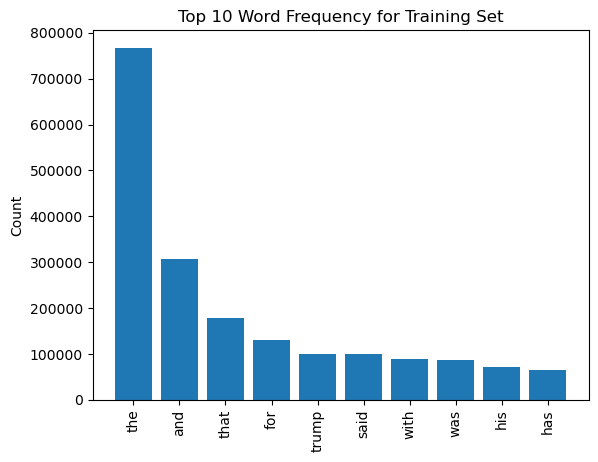

In [16]:
# Create a frequency distribution for X_train
train_freq_dist = FreqDist(X_train["tokenized_text"].explode())

# Plot the top 10 tokens
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for Training Set")

There are a lot of common, non-descriptive words in the top 10. We'll likely want to remove those down the line, but for our baseline model we'll leave them in. Before we can create this model, we have to flatten the corpus so that it can be interpreted by the computer.

In [17]:
flattened_Xtrain = pd.Series(list(itertools.chain(*X_train['tokenized_text'])))
flattened_Xtrain

0              trump
1               says
2              never
3             talked
4              putin
              ...   
10960624    pakistan
10960625         sri
10960626       lanka
10960627         and
10960628       syria
Length: 10960629, dtype: object

There are nearly 11 million tokens in our corpus! How many of them are unique?

In [18]:
print(len(pd.Series(flattened_Xtrain.unique())))

88221


That's almost 90,000 features for our model to take into account. Once we've constructed our baseline model, we'll need to simplify this significantly.

## Baseline Model
For our baseline model, we'll use a TF-IDF vectorizer and a naive Bayes classifier. Instead of just counting the instances of each term like the frequency distribution above, the TF-IDF vectorizer will assign each token a weight that represent the importance of each term in the document being analyzed. This will be important for helping us to analyze which words are most predictive of real vs. fake news later. If a term has the highest value of all the words for one document, that would mean that it appears frequently in the document and is relatively rare in the entire corpus, making it an important term for identifying the class of document.

In [19]:
# Convert token lists to strings
X_baseline_tokens = X_train["tokenized_text"].str.join(" ")

In [20]:
# instantiate, fit, and transform vectorizer
tfidf_baseline = TfidfVectorizer()
X_baseline_vec = tfidf_baseline.fit_transform(X_baseline_tokens)

In [21]:
baseline_model = MultinomialNB()
baseline_cv = cross_val_score(baseline_model, X_baseline_vec, y_train)
print(f'CV scores: {baseline_cv.round(4)}')
print(f'Mean CV score: {baseline_cv.mean().round(4)}')

CV scores: [0.928  0.9253 0.928  0.9286 0.933 ]
Mean CV score: 0.9286


Already, the model seems to be performing well - nearly a 93% accuracy on our validation folds. However, there are still steps we can take to improve our accuracy by further cleaning our data.

### Removing Stop Words
"Stop words" are commonly used words. They can pose a problem for natural language processing because they appear frequently in any document thus increasing the dimensionality of the feature set, but are insignificant for classification. Let's use NLTK's default list of stop words to begin to thin out our features, with the additions of "also" and "Reuters".

In [22]:
# import stopwords list
stopwords_list = stopwords.words('english')
stopwords_list.append(['also', 'reuters'])

# define a function to remove stopwords from a list of tokens
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    return [token for token in token_list if token not in stopwords_list]

In [23]:
X_train['stopwords_removed'] = X_train["tokenized_text"].apply(remove_stopwords)

In [24]:
X_train.head(2)

,title,text,tokenized_text,stopwords_removed
34830,"TRUMP DELIVERS MESSAGE TO PUTIN: “Russia, If You’re Listening…I Hope You’re Able To Find The 30,000 Emails That Are Missing” [VIDEO]","trump says he s never talked to putin and the allegation that he is working with him to expose hillary s emails is ridiculous. putin has been threatening the release of 20,000 emails from hillary s private server, and the press is trying to tie his threat to trump. unlike previous gop presidential candidates s trump s not going to sit back and allow the press to define the narrative. he s gett...","[trump, says, never, talked, putin, and, the, allegation, that, working, with, him, expose, hillary, emails, ridiculous, putin, has, been, threatening, the, release, emails, from, hillary, private, server, and, the, press, trying, tie, his, threat, trump, unlike, previous, gop, presidential, candidates, trump, not, going, sit, back, and, allow, the, press, define, the, narrative, getting, out,...","[trump, says, never, talked, putin, allegation, working, expose, hillary, emails, ridiculous, putin, threatening, release, emails, hillary, private, server, press, trying, tie, threat, trump, unlike, previous, gop, presidential, candidates, trump, going, sit, back, allow, press, define, narrative, getting, ahead, email, lie, taking, trump, style, popular, theory, explaining, attack, dnc, hack,..."
6018,Trump says he will 'absolutely do safe zones' in Syria,"washington () - u.s. president donald trump said he “will absolutely do safe zones in syria” to protect people fleeing violence there. “i’ll absolutely do safe zones in syria for the people,” trump said in an interview with abc news broadcast on wednesday. “i think that europe has made a tremendous mistake by allowing these millions of people to go into germany and various other countries,” he...","[washington, president, donald, trump, said, will, absolutely, safe, zones, syria, protect, people, fleeing, violence, there, absolutely, safe, zones, syria, for, the, people, trump, said, interview, with, abc, news, broadcast, wednesday, think, that, europe, has, made, tremendous, mistake, allowing, these, millions, people, into, germany, and, various, other, countries, said]","[washington, president, donald, trump, said, absolutely, safe, zones, syria, protect, people, fleeing, violence, absolutely, safe, zones, syria, people, trump, said, interview, abc, news, broadcast, wednesday, think, europe, made, tremendous, mistake, allowing, millions, people, germany, various, countries, said]"


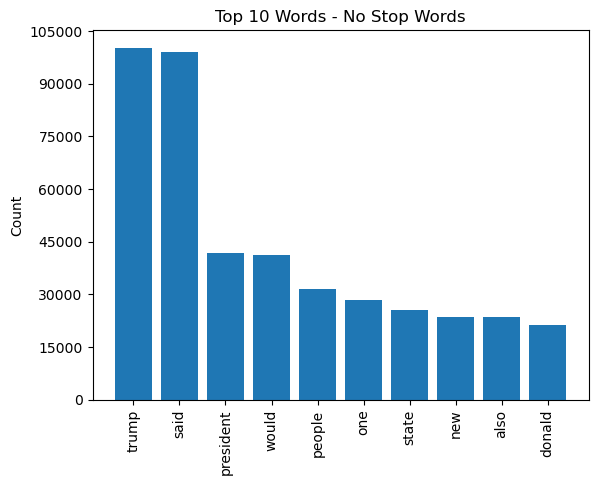

In [25]:
# Create a frequency distribution for X_train with stopwords removed
stopwords_freq_dist = FreqDist(X_train["stopwords_removed"].explode())

# Plot the top 10 tokens
visualize_top_10(stopwords_freq_dist, "Top 10 Words - No Stop Words")

In [26]:
flattened_nostopwords = pd.Series(list(itertools.chain(*X_train['stopwords_removed'])))
print(f'After removing stop words, there are {len(flattened_nostopwords)} tokens in the corpus,\
      {len(flattened_nostopwords.unique())} of which are unique.')
print(f'Before removing stop words, there were {len(flattened_Xtrain)} tokens in the corpus,\
      {len(flattened_Xtrain.unique())} of which were unique.')

After removing stop words, there are 7671232 tokens in the corpus,      88103 of which are unique.
Before removing stop words, there were 10960629 tokens in the corpus,      88221 of which were unique.


Without stop words included in the feature set, we can see that the most common words are now both more meaningful than those prior and are used less frequently. We can also see that we removed over 3 million words from the corpus, while only slightly reducing the dimensionality of the dataset. Let's see how this will impact our model.

## Second Model: No Stop Words

In [27]:
# Convert token lists to strings
X_nostopwords_tokens = X_train["stopwords_removed"].str.join(" ")

In [28]:
# instantiate, fit, and transform vectorizer
tfidf_nostopwords = TfidfVectorizer()
X_nostopwords_vec = tfidf_nostopwords.fit_transform(X_nostopwords_tokens)

In [29]:
nostopwords_model = MultinomialNB()
nostopwords_cv = cross_val_score(nostopwords_model, X_nostopwords_vec, y_train)
print(f'CV scores: {nostopwords_cv.round(4)}')
print(f'Mean CV score: {nostopwords_cv.mean().round(4)}')

CV scores: [0.9283 0.9252 0.9274 0.9284 0.9335]
Mean CV score: 0.9285


The performance from the baseline didn't really change. Let's try another step to see if we can make any improvements.

### Third Model: Lemmatization
Lemmatization is the process of reducing a word to its root. In the context of NLP, it helps us reduce the complexity of the corpus by taking words that come from the same root (i.e. "said" and "says") and counting them as part of the same feature. Let's create a master preprocessing function that takes care of all the preprocessing above, and lemmatizes the tokens as well.

In [30]:
def preprocess_text(text):
    
    # make all characters lowercase
    text = text.lower()
    
    # remove URLs, twitter names, etc
    url_pattern = r'(?:http|https|pic\.twitter|www\.)\S+|@\S+|^@\S+|#\S+'
    string =  re.sub(url_pattern, '', text, flags=re.IGNORECASE)
    
    # remove Reuters
    text = text.replace('reuters', '')
    
    # tokenize text
    basic_token_pattern = r"(?u)\b([a-zA-Z]{3,}|\d{4,})\b"
    tokenizer = RegexpTokenizer(basic_token_pattern)
    stopwords_list = stopwords.words('english')
    text = tokenizer.tokenize(text)
    text = [token.lower() for token in text if token.lower() not in stopwords_list]
    
    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(text))) 
    
    # lemmatizes each token based on part of speech in tuple
    doc = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]
    
    return text

In [31]:
X_train['lemmatized'] = X_train['text'].apply(preprocess_text)

In [32]:
X_train.head()

,title,text,tokenized_text,stopwords_removed,lemmatized
34830,"TRUMP DELIVERS MESSAGE TO PUTIN: “Russia, If You’re Listening…I Hope You’re Able To Find The 30,000 Emails That Are Missing” [VIDEO]","trump says he s never talked to putin and the allegation that he is working with him to expose hillary s emails is ridiculous. putin has been threatening the release of 20,000 emails from hillary s private server, and the press is trying to tie his threat to trump. unlike previous gop presidential candidates s trump s not going to sit back and allow the press to define the narrative. he s gett...","[trump, says, never, talked, putin, and, the, allegation, that, working, with, him, expose, hillary, emails, ridiculous, putin, has, been, threatening, the, release, emails, from, hillary, private, server, and, the, press, trying, tie, his, threat, trump, unlike, previous, gop, presidential, candidates, trump, not, going, sit, back, and, allow, the, press, define, the, narrative, getting, out,...","[trump, says, never, talked, putin, allegation, working, expose, hillary, emails, ridiculous, putin, threatening, release, emails, hillary, private, server, press, trying, tie, threat, trump, unlike, previous, gop, presidential, candidates, trump, going, sit, back, allow, press, define, narrative, getting, ahead, email, lie, taking, trump, style, popular, theory, explaining, attack, dnc, hack,...","[trump, says, never, talked, putin, allegation, working, expose, hillary, emails, ridiculous, putin, threatening, release, emails, hillary, private, server, press, trying, tie, threat, trump, unlike, previous, gop, presidential, candidates, trump, going, sit, back, allow, press, define, narrative, getting, ahead, email, lie, taking, trump, style, popular, theory, explaining, attack, dnc, hack,..."
6018,Trump says he will 'absolutely do safe zones' in Syria,"washington () - u.s. president donald trump said he “will absolutely do safe zones in syria” to protect people fleeing violence there. “i’ll absolutely do safe zones in syria for the people,” trump said in an interview with abc news broadcast on wednesday. “i think that europe has made a tremendous mistake by allowing these millions of people to go into germany and various other countries,” he...","[washington, president, donald, trump, said, will, absolutely, safe, zones, syria, protect, people, fleeing, violence, there, absolutely, safe, zones, syria, for, the, people, trump, said, interview, with, abc, news, broadcast, wednesday, think, that, europe, has, made, tremendous, mistake, allowing, these, millions, people, into, germany, and, various, other, countries, said]","[washington, president, donald, trump, said, absolutely, safe, zones, syria, protect, people, fleeing, violence, absolutely, safe, zones, syria, people, trump, said, interview, abc, news, broadcast, wednesday, think, europe, made, tremendous, mistake, allowing, millions, people, germany, various, countries, said]","[washington, president, donald, trump, said, absolutely, safe, zones, syria, protect, people, fleeing, violence, absolutely, safe, zones, syria, people, trump, said, interview, abc, news, broadcast, wednesday, think, europe, made, tremendous, mistake, allowing, millions, people, germany, various, countries, said]"
42549,MUSLIM BROTHERHOOD AFFILIATE INVITED To Obama’s State Of The Union…Will This Terror Group Also Be Invited?,"so in an effort to reach out to muslims living in america, we need to invite groups that are tied to terrorists? why stop at groups like cair? why not invite isis? perhaps we missed it, but we haven t seen the list of prominent christian leaders invited to obama s sotu, who will represent the worldwide mass persecution of christians as many as 25 house democrats are expected to have muslim gue...","[effort, reach, out, muslims, living, america, need, invite, groups, that, are, tied, terrorists, why, stop, groups, like, cair, why, not, invite, isis, perhaps, missed, but, haven, seen, the, list, pr

What does our list of most frequently appearing terms look like now?

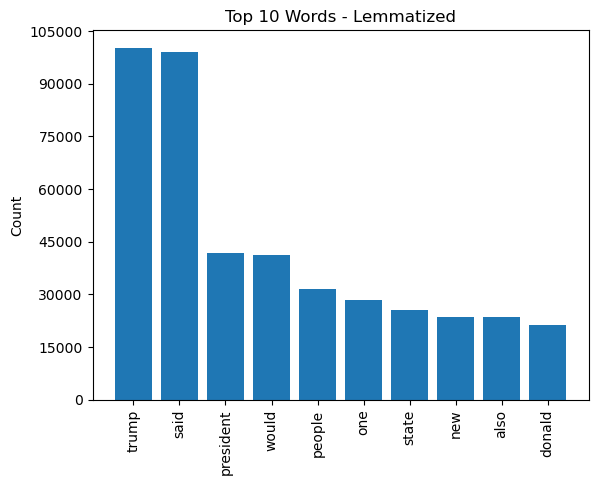

In [33]:
lemmatized_dist = FreqDist(X_train["lemmatized"].explode())
visualize_top_10(lemmatized_dist, "Top 10 Words - Lemmatized")

In [34]:
flattened_lemmatization = pd.Series(list(itertools.chain(*X_train['lemmatized'])))
print(f'After removing stop words and lemmatizing, there are {len(flattened_lemmatization)} tokens in the corpus,\
      {len(flattened_lemmatization.unique())} of which are unique.')
print(f'After removing stop words but before lemmatizing, there were {len(flattened_nostopwords)} tokens in the corpus,\
      {len(flattened_nostopwords.unique())} of which are unique.')
print(f'Before removing stop words, there were {len(flattened_Xtrain)} tokens in the corpus,\
      {len(flattened_Xtrain.unique())} of which were unique.')

After removing stop words and lemmatizing, there are 7671232 tokens in the corpus,      88103 of which are unique.
After removing stop words but before lemmatizing, there were 7671232 tokens in the corpus,      88103 of which are unique.
Before removing stop words, there were 10960629 tokens in the corpus,      88221 of which were unique.


We succeeded in further reducing both the size of the corpus and the number of features. How will this impact our model?

In [35]:
# Convert token lists to strings
X_lemm_tokens = X_train["lemmatized"].str.join(" ")

In [36]:
# instantiate, fit, and transform vectorizer
tfidf_lemm = TfidfVectorizer()
X_lemm_vec = tfidf_lemm.fit_transform(X_lemm_tokens)

In [37]:
lemm_model = MultinomialNB()
lemm_cv = cross_val_score(lemm_model, X_lemm_vec, y_train)

print(f'CV scores: {lemm_cv.round(4)}')
print(f'Mean CV score: {lemm_cv.mean().round(4)}')

CV scores: [0.9283 0.9252 0.9274 0.9284 0.9335]
Mean CV score: 0.9285


It looks like we're at about the same place we were before lemmatization. Next, let's try testing a variety of different modeling techniques that are based on different underlying decision metrics to see which performs the best on our validation folds.

## Model 4: Testing Different Models

We'll track the accuracy of each model in a table and select the model with the highest score.

In [38]:
# create table and keep bayes score
evaluation = pd.DataFrame({'Model': [],
                           'Mean CV Accuracy':[]})

evaluation.loc[0] = ['Naive Bayes', lemm_cv.mean().round(4)]
evaluation

,Model,Mean CV Accuracy
0,Naive Bayes,0.9285


Next, we'll try a logistic regression.

In [39]:
# instantiate and fit logistic regression
lr_model = LogisticRegression()
lr_model.fit(X_lemm_vec, y_train)
lr_cv = cross_val_score(lr_model, X_lemm_vec, y_train)

# store score in table
evaluation.loc[1] = ['Logistic Reg.', lr_cv.mean().round(4)]
evaluation

,Model,Mean CV Accuracy
0,Naive Bayes,0.9285
1,Logistic Reg.,0.9763


That performs significantly better than the Bayes. How about a Linear Support Vector Classification (SVC)?

In [40]:
svc_model = LinearSVC()
svc_model.fit(X_lemm_vec, y_train)
svc_cv = cross_val_score(svc_model, X_lemm_vec, y_train)

evaluation.loc[2] = ['SVC', svc_cv.mean().round(4)]
evaluation

,Model,Mean CV Accuracy
0,Naive Bayes,0.9285
1,Logistic Reg.,0.9763
2,SVC,0.9854


That's our best model so far. Finally, we'll try a tree-based Random Forest Classifier.

In [41]:
rf_model = RandomForestClassifier()
rf_model.fit(X_lemm_vec, y_train)
rf_cv = cross_val_score(rf_model, X_lemm_vec, y_train)

evaluation.loc[3] = ['Random Forest', rf_cv.mean().round(4)]
evaluation

,Model,Mean CV Accuracy
0,Naive Bayes,0.9285
1,Logistic Reg.,0.9763
2,SVC,0.9854
3,Random Forest,0.9766


It looks like our best model is the Linear SVC. Now we can tune the hyperparameters on that model using a grid search to ensure the best possible performance.

### Hyperparameter Tuning for Linear SVC

In [42]:
# instantiate linear svc and pipeline
svc_model_pipe = LinearSVC()
svc_pipe = Pipeline([('model', svc_model_pipe)])
svc_params = {'model__C': [0.01, 0.1, 1], 
              'model__tol': [1e-6, 1e-4, 1e-2, 1], 
              'model__max_iter': [1000, 2000, 3000]}
svc_gs = GridSearchCV(estimator = svc_pipe, param_grid = svc_params, 
                      cv = 5, scoring = 'accuracy', return_train_score=True)

In [43]:
svc_gs.fit(X_lemm_vec, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', LinearSVC())]),
             param_grid={'model__C': [0.01, 0.1, 1],
                         'model__max_iter': [1000, 2000, 3000],
                         'model__tol': [1e-06, 0.0001, 0.01, 1]},
             return_train_score=True, scoring='accuracy')

In [44]:
pd.DataFrame(svc_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__max_iter,param_model__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.216478,0.002620,0.001728,0.000038,0.01,1000,0.000001,"{'model__C': 0.01, 'model__max_iter': 1000, 'model__tol': 1e-06}",0.960802,0.958723,0.959169,0.957380,0.962875,0.959790,0.001891,25,0.963657,0.964029,0.963843,0.964772,0.963733,0.964007,0.000403
1,0.174555,0.008092,0.001782,0.000069,0.01,1000,0.0001,"{'model__C': 0.01, 'model__max_iter': 1000, 'model__tol': 0.0001}",0.960802,0.958723,0.959169,0.957380,0.962875,0.959790,0.001891,25,0.963657,0.964029,0.963843,0.964772,0.963733,0.964007,0.000403
2,0.128454,0.001869,0.001745,0.000027,0.01,1000,0.01,"{'model__C': 0.01, 'model__max_iter': 1000, 'model__tol': 0.01}",0.960802,0.958723,0.959169,0.957380,0.962875,0.959790,0.001891,25,0.963657,0.964029,0.963843,0.964772,0.963733,0.964007,0.000403
3,0.064066,0.001213,0.001693,0.000032,0.01,1000,1,"{'model__C': 0.01, 'model__max_iter': 1000, 'model__tol': 1}",0.960059,0.958575,0.959169,0.957677,0.962578,0.959612,0.001674,34,0.962952,0.963360,0.963397,0.964512,0.963436,0.963532,0.000520
4,0.214449,0.002805,0.001749,0.000048,0.01,2000,0.000001,"{'model__C': 0.01, 'model__max_iter': 2000, 'model__tol': 1e-06}",0.960802,0.958723,0.959169,0.957380,0.962875,0.959790,0.001891,25,0.963657,0.964029,0.963843,0.964772,0.963733,0.964007,0.000403
5,0.176238,0.004678,0.001764,0.000040,0.01,2000,0.0001,"{'model__C': 0.01, 'model__max_iter': 2000, 'model__tol': 0.0001}",0.960802,0.958723,0.959169,0.957380,0.962875,0.959790,0.001891,25,0.963657,0.964029,0.963843,0.964772,0.963733,0.964007,0.000403
6,0.128566,0.002046,0.001709,0.000048,0.01,2000,0.01,"{'model__C': 0.01, 'model__max_iter': 2000, 'model__tol': 0.01}",0.960802,0.958723,0.959169,0.957380,0.962875,0.959790,0.001891,25,0.963657,0.964029,0.963843,0.964772,0.963733,0.964007,0.000403
7,0.068610,0.002162,0.001794,0.000072,0.01,2000,1,"{'model__C': 0.01, 'model__max_iter': 2000, 'model__tol': 1}",0.960653,0.958129,0.958575,0.957529,0.962726,0.959523,0.001916,35,0.962915,0.963286,0.963286,0.964401,0.963473,0.963472,0.000499
8,0.214340,0.001735,0.001713,0.000025,0.01,3000,0.000001,"{'model__C': 0.01, 'model__max_iter': 3000, 'model__tol': 1e-06}",0.960802,0.958723,0.959169,0.957380,0.962875,0.959790,0.001891,25,0.963657,0.964029,0.963843,0.964772,0.963733,0.964007,0.000403
9,0.167349,0.006146,0.001689,0.000023,0.01,3000,0.0001,"{'model__C': 0.01, 'model__max_iter': 3000, 'model__tol': 0.0001}",0.960802,0.958723,0.959169,0.957380,0.962875,0.959790,0.001891,25,0.963657,0.964029,0.963843,0.964772,0.963733,0.964007,0.000403


In [45]:
svc_gs.best_estimator_

Pipeline(steps=[('model', LinearSVC(C=1, max_iter=3000, tol=1))])

In [46]:
# set model hyperparameters to those of model with best cross val results
best_svc_model = svc_gs.best_estimator_

# run cross validation
best_svc_model.fit(X_lemm_vec, y_train)
svc_cv_gs = cross_val_score(best_svc_model, X_lemm_vec, y_train)

# store in table
evaluation.loc[4] = ['Tuned SVC', svc_cv_gs.mean().round(4)]
evaluation

,Model,Mean CV Accuracy
0,Naive Bayes,0.9285
1,Logistic Reg.,0.9763
2,SVC,0.9854
3,Random Forest,0.9766
4,Tuned SVC,0.9856


In [48]:
X_test['lemmatized'] = X_test['text'].apply(preprocess_text)

In [49]:
# Convert token lists to strings
X_test_lemm_tokens = X_test["lemmatized"].str.join(" ")
X_test_lemm_vec = tfidf_lemm.transform(X_test_lemm_tokens)
best_svc_model.score(X_test_lemm_vec, y_test)

0.9883296213808463

In [70]:
# save model for Streamlit app
with open('best_svc_model.pkl','wb') as f:
    pickle.dump(best_svc_model,f)

In [71]:
# save vectorizer for Streamlit app
with open('tfidf_lemm.pkl','wb') as e:
    pickle.dump(tfidf_lemm,e)

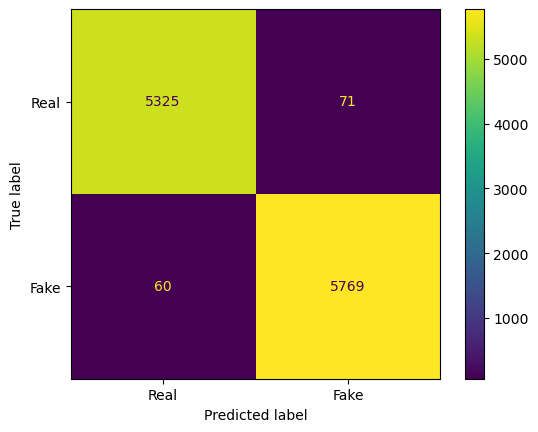

In [50]:
ConfusionMatrixDisplay.from_estimator(best_svc_model, X_test_lemm_vec, y_test, 
                                      display_labels=["Real", "Fake"]);

Overall, the model is performing very well - about 98.8% of the predictions on unseen data are correct. **We can select this tuned Linear SVC model as our final model based on these results.** Let's make predictions for the full dataset and start doing some evaluation. 

## Applying the Model to the Full Dataset

In [52]:
news['lemmatized'] = news['text'].apply(preprocess_text)
news

,title,text,target,lemmatized
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a ...",0,"[washington, head, conservative, republican, faction, congress, voted, month, huge, expansion, national, debt, pay, tax, cuts, called, fiscal, conservative, sunday, urged, budget, restraint, 2018, keeping, sharp, pivot, way, among, republicans, representative, mark, meadows, speaking, cbs, face, nation, drew, hard, line, federal, spending, lawmakers, bracing, battle, january, return, holidays,..."
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administra...",0,"[washington, transgender, people, allowed, first, time, enlist, military, starting, monday, ordered, federal, courts, pentagon, said, friday, president, donald, trump, administration, decided, appeal, rulings, blocked, transgender, ban, two, federal, appeals, courts, one, washington, one, virginia, last, week, rejected, administration, request, put, hold, orders, lower, court, judges, requirin..."
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, sai...",0,"[washington, special, counsel, investigation, links, russia, president, trump, 2016, election, campaign, continue, without, interference, 2018, despite, calls, trump, administration, allies, republican, lawmakers, shut, prominent, republican, senator, said, sunday, lindsey, graham, serves, senate, armed, forces, judiciary, committees, said, department, justice, special, counsel, robert, muelle..."
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence in...",0,"[washington, trump, campaign, adviser, george, papadopoulos, told, australian, diplomat, may, 2016, russia, political, dirt, democratic, presidential, candidate, hillary, clinton, new, york, times, reported, saturday, conversation, papadopoulos, diplomat, alexander, downer, london, driving, factor, behind, fbi, decision, open, counter, intelligence, investigation, moscow, contacts, trump, camp..."
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past. “Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packa...",0,"[seattle, wa

In [53]:
news_lemm_tokens = news["lemmatized"].str.join(" ")
news_lemm_vec = tfidf_lemm.transform(news_lemm_tokens)
news['predictions'] = best_svc_model.predict(news_lemm_vec)
news.head()

,title,text,target,lemmatized,predictions
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a ...",0,"[washington, head, conservative, republican, faction, congress, voted, month, huge, expansion, national, debt, pay, tax, cuts, called, fiscal, conservative, sunday, urged, budget, restraint, 2018, keeping, sharp, pivot, way, among, republicans, representative, mark, meadows, speaking, cbs, face, nation, drew, hard, line, federal, spending, lawmakers, bracing, battle, january, return, holidays,...",0
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administra...",0,"[washington, transgender, people, allowed, first, time, enlist, military, starting, monday, ordered, federal, courts, pentagon, said, friday, president, donald, trump, administration, decided, appeal, rulings, blocked, transgender, ban, two, federal, appeals, courts, one, washington, one, virginia, last, week, rejected, administration, request, put, hold, orders, lower, court, judges, requirin...",0
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, sai...",0,"[washington, special, counsel, investigation, links, russia, president, trump, 2016, election, campaign, continue, without, interference, 2018, despite, calls, trump, administration, allies, republican, lawmakers, shut, prominent, republican, senator, said, sunday, lindsey, graham, serves, senate, armed, forces, judiciary, committees, said, department, justice, special, counsel, robert, muelle...",0
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence in...",0,"[washington, trump, campaign, adviser, george, papadopoulos, told, australian, diplomat, may, 2016, russia, political, dirt, democratic, presidential, candidate, hillary, clinton, new, york, times, reported, saturday, conversation, papadopoulos, diplomat, alexander, downer, london, driving, factor, behind, fbi, decision, open, counter, intelligence, investigation, moscow, contacts, trump, camp...",0
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past. “Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packa

In [54]:
realcorrect = news.loc[(news['target'] == 0) & (news['predictions'] == 0)]
fakecorrect = news.loc[(news['target'] == 1) & (news['predictions'] == 1)]
realwrong = news.loc[(news['target'] == 1) & (news['predictions'] == 0)]
fakewrong = news.loc[(news['target'] == 0) & (news['predictions'] == 1)]

In [55]:
realcorrect.head(2)

,title,text,target,lemmatized,predictions
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a ...",0,"[washington, head, conservative, republican, faction, congress, voted, month, huge, expansion, national, debt, pay, tax, cuts, called, fiscal, conservative, sunday, urged, budget, restraint, 2018, keeping, sharp, pivot, way, among, republicans, representative, mark, meadows, speaking, cbs, face, nation, drew, hard, line, federal, spending, lawmakers, bracing, battle, january, return, holidays,...",0
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administra...",0,"[washington, transgender, people, allowed, first, time, enlist, military, starting, monday, ordered, federal, courts, pentagon, said, friday, president, donald, trump, administration, decided, appeal, rulings, blocked, transgender, ban, two, federal, appeals, courts, one, washington, one, virginia, last, week, rejected, administration, request, put, hold, orders, lower, court, judges, requirin...",0


In [56]:
fakecorrect.head(2)

,title,text,target,lemmatized,predictions
21417,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dis...",1,"[donald, trump, wish, americans, happy, new, year, leave, instead, give, shout, enemies, haters, dishonest, fake, news, media, former, reality, show, star, one, job, country, rapidly, grows, stronger, smarter, want, wish, friends, supporters, enemies, haters, even, dishonest, fake, news, media, happy, healthy, new, year, president, angry, pants, tweeted, 2018, great, year, america, country, ra...",1
21418,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained...",1,"[house, intelligence, committee, chairman, devin, nunes, going, bad, day, assumption, like, many, christopher, steele, dossier, prompted, russia, investigation, lashing, department, justice, fbi, order, protect, trump, happens, dossier, started, investigation, according, documents, obtained, new, york, times, former, trump, campaign, adviser, george, papadopoulos, drunk, wine, bar, revealed, k...",1


In [57]:
realwrong.head(2)

,title,text,target,lemmatized,predictions
22227,Senate Gives Trump Jr. Ultimatum: Respond By Friday Or Face Subpoena,"The Senate Judiciary Committee just gave former Trump campaign manager Paul Manafort and Donald Trump Jr. a decision to make by Friday evening and the clock is ticking. The Committee has pre-approved subpoenas in order to force Manafort and Don Jr. to appear before the panel if they do not accept by Friday evening an invitation to appear next week, the Washington Post reports.Charles E. Grassl...",1,"[senate, judiciary, committee, gave, former, trump, campaign, manager, paul, manafort, donald, trump, decision, make, friday, evening, clock, ticking, committee, pre, approved, subpoenas, order, force, manafort, appear, panel, accept, friday, evening, invitation, appear, next, week, washington, post, reports, charles, grassley, iowa, committee, chairman, said, manafort, trump, third, invited, ...",0
23096,Court Slams Down Trump’s Order Blocking Funding To Sanctuary Cities,"During the 2016 presidential campaign, President Donald Trump made a lot of promises on immigration. He was going to build a wall between the United States and Mexico, that Mexico would fund. He was going to keep Muslims from coming into the country. Lastly, he was going to cut funding to sanctuary cities. Now it looks like none of that is going to happen. The travel bans have been struck do...",1,"[2016, presidential, campaign, president, donald, trump, made, lot, promises, immigration, going, build, wall, united, states, mexico, mexico, would, fund, going, keep, muslims, coming, country, lastly, going, cut, funding, sanctuary, cities, looks, like, none, going, happen, travel, bans, struck, border, wall, never, going, happen, federal, court, ruled, taking, funding, away, sanctuary, citi...",0


In [58]:
fakewrong.head(2)

,title,text,target,lemmatized,predictions
303,Trump ally Bannon campaigns for Moore in Alabama,"(Reuters) - A day after President Donald Trump endorsed U.S. Senate candidate Roy Moore of Alabama, Trump’s former chief strategist Steve Bannon campaigned in the state, telling a crowd that allegations of sexual misconduct against Moore were part of a smear campaign to keep him from office. “They want to destroy Judge Roy Moore and you know why?” Bannon asked at the rally in Fairhope, Alabam...",0,"[day, president, donald, trump, endorsed, senate, candidate, roy, moore, alabama, trump, former, chief, strategist, steve, bannon, campaigned, state, telling, crowd, allegations, sexual, misconduct, moore, part, smear, campaign, keep, office, want, destroy, judge, roy, moore, know, bannon, asked, rally, fairhope, alabama, want, take, voice, away, trump, originally, supported, moore, opponent, ...",1
324,"Trump, Obama dominate Twitter year, but chicken nuggets prevail","(Reuters) - U.S. President Donald Trump continued to dominate Twitter in 2017 even though former President Barack Obama’s tweets were more liked and both were blown away by one man’s quest for free chicken nuggets. Twitter revealed the year’s most liked and retweeted tweets on Tuesday, reflecting how a nation bitterly divided between Republicans and Democrats is likewise split on social media....",0,"[president, donald, trump, continued, dominate, twitter, 2017, even, though, former, president, barack, obama, tweets, liked, blown, away, one, man, quest, free, chicken, nuggets, twitter, revealed, year, liked, retweeted, tweets, tuesday, reflecting, nation, bitterly, divided, republicans, democrats, likewise, split, social, media, trump, whose, million, followers, realdonaldtrump, rank, twit...",1


## Model 5: Model Using Word Embeddings From GloVe

Up to this point, we've been using a TF-IDF vectorizer to assign weights to words based on their presence (and rarity) across each individual document and the entire corpus. For this next model, we'll use [Global Vectors for Word Representation (GloVe) from the Stanford NLP group](https://nlp.stanford.edu/projects/glove/), which is a pre-trained set of 50-dimensional word vectors for 6 billion words. While the TF-IDF vectorizer is trained only on the words in this corpus, the GloVe vectors are trained on a massive quantity of text data and uses word co-occurrences to understand the relationships between words. To start, we'll need to construct a vocabulary of the unique words in our corpus:

In [59]:
# # create vocabulary
# vocab = set(token for tokens in X_lemm_tokens for token in tokens.split())
# len(vocab)

In [60]:
# # create dictionary with tokens and vectors from GloVe
# glove = {}
# with open('data/glove.6B/glove.6B.300d.txt', 'rb') as f:
#     for line in f:
#         parts = line.split()
#         word = parts[0].decode('utf-8')
#         if word in vocab:
#             vector = np.array(parts[1:], dtype=np.float32)
#             glove[word] = vector

In [61]:
# len(glove)

Now we need to create a Word2Vec class that will allow us to use the mean word embedding values for each token in a pipeline.

In [62]:
# # with gratitude to the Flatiron School for the code for this class
# class W2vVectorizer(object):
    
#     def __init__(self, w2v):
#         # Takes in a dictionary of words and vectors as input
#         self.w2v = w2v
#         if len(w2v) == 0:
#             self.dimensions = 0
#         else:
#             self.dimensions = len(w2v[next(iter(glove))])
    
#     # for use in a pipeline
#     def fit(self, X, y):
#         return self
            
#     def transform(self, X):
#         return np.array([
#             np.mean([self.w2v[w] for w in words if w in self.w2v]
#                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [63]:
# # use the W2V class in our pipeline
# svc_glove_pipe = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
#                 ('SVC', LinearSVC(max_iter = 2500))])

In [64]:
# # fit it to the data
# svc_glove_pipe.fit(X_lemm_tokens, y_train)

In [65]:
# # get the cross validation score
# w2v_cv = cross_val_score(svc_glove_pipe, X_lemm_tokens, y_train)

In [66]:
# # print the scores
# w2v_cv

In [67]:
# # get the score on the test data
# svc_glove_pipe.score(X_test_lemm_tokens, y_test)

That doesn't seem to have gotten us anywhere. Let's try a different approach.